In [2]:
# If running in Colab, uncomment the next line the very first time.
# !pip install --quiet pandas numpy polars pyarrow scipy scikit-learn tensorflow matplotlib

import os, math, typing, itertools, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import polars as pl
from dataclasses import dataclass

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

np.random.seed(42)
tf.random.set_seed(42)

print(tf.__version__)


2.19.0


In [3]:
# === CONFIG YOU SHOULD REVIEW ===

# Where your monthly CRSP-like file is. Change this to your path in Colab/Drive.
CSV_PATH = "/content/drive/MyDrive/MSF_1996_2023.csv"   # e.g., upload and set path
# If your file name contains spaces/parentheses, it's fine; just paste the exact path.

START_YEAR = 2005
END_YEAR   = 2023

# Per-year, per-industry sample cap to keep the dataset tractable (and aligned to rubric).
SAMPLE_PER_INDUSTRY_PER_YEAR = 10

# Lookback windows (months) to build rolling features over [t-w+1, ..., t]
LOOKBACK_WINDOWS = [12, 24, 36]   # you can add/remove

# Train/Val/Test splits by calendar month (no leakage)
TRAIN_END   = "2012-12-31"
VAL_END     = "2017-12-31"
TEST_END    = "2023-12-31"

RANDOM_SEED = 7
np.random.seed(RANDOM_SEED)


In [4]:
# Expecting a CRSP monthly-style file with at least:
# PERMNO, DATE (YYYY-MM-DD or YYYYMMDD), RET (decimal), PRC, SHROUT, VOL, VWRETD (market return, decimal)
# If your file uses different names, map them below.

colmap_candidates = {
    "permno": ["permno","PERMNO","Permno"],
    "date": ["date","DATE","Date"],
    "ret": ["ret","RET"],
    "prc": ["prc","PRC"],
    "shrout": ["shrout","SHROUT","SHROUTS"],
    "vol": ["vol","VOL","VOLUME"],
    "mktret": ["vwretd","VWRETD","Mkt-RF","MKT","MKTRET","MktRet"],  # adjust if needed
    "siccd": ["siccd","SICCD","SIC"]
}

def auto_pick(df, keys):
    for k in keys:
        if k in df.columns:
            return k
    return None

# Load with pandas (robust for mixed types); we’ll use polars later for speed
raw = pd.read_csv(CSV_PATH)
raw_columns = {c:str(c) for c in raw.columns}
raw.rename(columns=raw_columns, inplace=True)

# Build a map from standard name -> actual column name in file
colmap = {std: auto_pick(raw, cand) for std, cand in colmap_candidates.items()}

missing = [k for k,v in colmap.items() if v is None and k not in ("vol","siccd")]
if missing:
    raise RuntimeError(f"Your CSV is missing required columns for: {missing}\nFound columns: {list(raw.columns)}")

# Parse date
if colmap["date"] is None:
    raise RuntimeError("No DATE column found after mapping.")
raw["_date"] = pd.to_datetime(raw[colmap["date"]], errors="coerce")
raw = raw.dropna(subset=["_date"])

# Filter year range
raw = raw[(raw["_date"].dt.year >= START_YEAR) & (raw["_date"].dt.year <= END_YEAR)].copy()

# Standardize numeric columns
def safe_to_numeric(s):
    return pd.to_numeric(s, errors="coerce")

for k in ["ret","prc","shrout","vol","mktret","siccd"]:
    if colmap.get(k):
        raw[f"_{k}"] = safe_to_numeric(raw[colmap[k]])
    else:
        raw[f"_{k}"] = np.nan

# Market cap and clean returns
raw["_mcap"] = (raw["_prc"].abs() * raw["_shrout"]) / 1000.0  # CRSP shrout generally in thousands
raw["_year"] = raw["_date"].dt.year
raw["_ym"] = raw["_date"].dt.to_period("M").dt.to_timestamp()

# Keep essential standardized view
keep_cols = ["_date","_ym","_year","_ret","_prc","_shrout","_vol","_mktret","_mcap", colmap["permno"]]
if colmap.get("siccd"): keep_cols.append("_siccd")
df = raw[keep_cols].rename(columns={colmap["permno"]:"permno"})
df = df.sort_values(["permno","_ym"]).reset_index(drop=True)

print(df.head(3))
print(df.columns.tolist())


       _date        _ym  _year      _ret   _prc  _shrout    _vol   _mktret  \
0 2005-01-31 2005-01-01   2005 -0.040580  6.620   2595.0   515.0 -0.026546   
1 2005-02-28 2005-02-01   2005 -0.045166  6.321   2599.0   726.0  0.022646   
2 2005-03-31 2005-03-01   2005  0.124822  7.110   2625.0  4107.0 -0.016944   

       _mcap  permno  _siccd  
0  17.178900   10001  4920.0  
1  16.428279   10001  4920.0  
2  18.663750   10001  4920.0  
['_date', '_ym', '_year', '_ret', '_prc', '_shrout', '_vol', '_mktret', '_mcap', 'permno', '_siccd']


In [5]:
# Simple Fama-French-like coarse buckets from SIC. Adjust if your rubric defines a specific mapping.

def sic_to_industry(sic: float) -> str:
    try:
        s = int(sic)
    except:
        return "Unknown"
    # Extremely coarse mapping for illustration; refine as you see fit.
    if 100 <= s < 1000:   return "Agriculture"
    if 1000 <= s < 1500:  return "Mining"
    if 1500 <= s < 1800:  return "Construction"
    if 2000 <= s < 4000:  return "Manufacturing"
    if 4000 <= s < 5000:  return "Transport/Utilities"
    if 5000 <= s < 5200:  return "Wholesale"
    if 5200 <= s < 6000:  return "Retail"
    if 6000 <= s < 6800:  return "Finance"
    if 7000 <= s < 9000:  return "Services"
    return "Other"

df["industry"] = "Unknown"
if "_siccd" in df.columns:
    df["industry"] = df["_siccd"].apply(sic_to_industry)

df["industry"] = df["industry"].astype("category")
df["permno"]   = df["permno"].astype(int)
print(df[["permno","_ym","industry"]].head())


   permno        _ym             industry
0   10001 2005-01-01  Transport/Utilities
1   10001 2005-02-01  Transport/Utilities
2   10001 2005-03-01  Transport/Utilities
3   10001 2005-04-01  Transport/Utilities
4   10001 2005-05-01  Transport/Utilities


In [6]:
# Simple Fama-French-like coarse buckets from SIC. Adjust if your rubric defines a specific mapping.

def sic_to_industry(sic: float) -> str:
    try:
        s = int(sic)
    except:
        return "Unknown"
    # Extremely coarse mapping for illustration; refine as you see fit.
    if 100 <= s < 1000:   return "Agriculture"
    if 1000 <= s < 1500:  return "Mining"
    if 1500 <= s < 1800:  return "Construction"
    if 2000 <= s < 4000:  return "Manufacturing"
    if 4000 <= s < 5000:  return "Transport/Utilities"
    if 5000 <= s < 5200:  return "Wholesale"
    if 5200 <= s < 6000:  return "Retail"
    if 6000 <= s < 6800:  return "Finance"
    if 7000 <= s < 9000:  return "Services"
    return "Other"

df["industry"] = "Unknown"
if "_siccd" in df.columns:
    df["industry"] = df["_siccd"].apply(sic_to_industry)

df["industry"] = df["industry"].astype("category")
df["permno"]   = df["permno"].astype(int)
print(df[["permno","_ym","industry"]].head())


   permno        _ym             industry
0   10001 2005-01-01  Transport/Utilities
1   10001 2005-02-01  Transport/Utilities
2   10001 2005-03-01  Transport/Utilities
3   10001 2005-04-01  Transport/Utilities
4   10001 2005-05-01  Transport/Utilities


In [7]:
rng = np.random.default_rng(RANDOM_SEED)

def sample_panel(d: pd.DataFrame, per_industry_per_year=10) -> pd.DataFrame:
    out = []
    for yr, d_y in d.groupby("_year"):
        for ind, d_yi in d_y.groupby("industry"):
            firms = d_yi["permno"].unique()
            if len(firms) > per_industry_per_year:
                picked = rng.choice(firms, size=per_industry_per_year, replace=False)
            else:
                picked = firms
            out.append(d_yi[d_yi["permno"].isin(picked)])
    return pd.concat(out, axis=0).sort_values(["permno","_ym"]).reset_index(drop=True)

df_s = sample_panel(df, SAMPLE_PER_INDUSTRY_PER_YEAR)
print("Panel sample shape:", df_s.shape, "unique permno:", df_s["permno"].nunique())


Panel sample shape: (21164, 12) unique permno: 1347


In [8]:
def rolling_features(group: pd.DataFrame, windows: typing.List[int]) -> pd.DataFrame:
    g = group.copy()
    for w in windows:
        ret = g["_ret"]
        # Basic moments
        g[f"ret_mean_{w}"] = ret.rolling(w, min_periods=w//2).mean()
        g[f"ret_std_{w}"]  = ret.rolling(w, min_periods=w//2).std()
        g[f"ret_min_{w}"]  = ret.rolling(w, min_periods=w//2).min()
        g[f"ret_max_{w}"]  = ret.rolling(w, min_periods=w//2).max()
        # Skew/kurt via scipy-like formulas (manual, robust to NaN)
        def skew_rolling(x):
            x = x.dropna()
            if len(x) < 3: return np.nan
            m = x.mean(); s = x.std(ddof=0)
            if s == 0: return 0.0
            return ((x - m)**3).mean() / (s**3)
        def kurt_rolling(x):
            x = x.dropna()
            if len(x) < 4: return np.nan
            m = x.mean(); s = x.std(ddof=0)
            if s == 0: return 0.0
            return ((x - m)**4).mean() / (s**4) - 3.0
        g[f"ret_skew_{w}"] = ret.rolling(w).apply(skew_rolling, raw=False)
        g[f"ret_kurt_{w}"] = ret.rolling(w).apply(kurt_rolling, raw=False)
        # Autocorr(1)
        g[f"ret_ac1_{w}"] = ret.rolling(w).apply(lambda x: pd.Series(x).autocorr(lag=1), raw=False)
        # Market stats
        m = g["_mktret"]
        g[f"mkt_mean_{w}"] = m.rolling(w, min_periods=w//2).mean()
        g[f"mkt_std_{w}"]  = m.rolling(w, min_periods=w//2).std()
        # Simple rolling beta (feature, not the target)
        # cov(ret, mkt)/var(mkt)
        cov = ret.rolling(w).cov(m)
        var = m.rolling(w).var()
        g[f"beta_lin_{w}"] = cov / var

        # Liquidity/size proxies
        g[f"log_mcap_{w}"] = np.log1p(g["_mcap"].rolling(w, min_periods=w//2).mean())
        if "_vol" in g.columns:
            g[f"log_vol_mean_{w}"] = np.log1p(g["_vol"].rolling(w, min_periods=w//2).mean())
            g[f"log_vol_std_{w}"]  = np.log1p(g["_vol"].rolling(w, min_periods=w//2).std())
    return g

# Apply by permno
features = []
for pid, g in df_s.groupby("permno"):
    features.append(rolling_features(g, LOOKBACK_WINDOWS))
feat_df = pd.concat(features, axis=0).sort_values(["permno","_ym"]).reset_index(drop=True)

# Add simple one-hot for industry (keeps interpretability)
ind_dummies = pd.get_dummies(feat_df["industry"], prefix="ind", dummy_na=False)
feat_df = pd.concat([feat_df, ind_dummies], axis=1)

print("Feature columns added:", len([c for c in feat_df.columns if c.startswith(("ret_","mkt_","beta_lin_","log_","ind_"))]))
feat_df.head(3)


Feature columns added: 50


,_date,_ym,_year,_ret,_prc,_shrout,_vol,_mktret,_mcap,permno,...,ind_Construction,ind_Finance,ind_Manufacturing,ind_Mining,ind_Other,ind_Retail,ind_Services,ind_Transport/Utilities,ind_Unknown,ind_Wholesale
0,2020-01-31,2020-01-01,2020,-0.100016,165.84000,18919.0,22433.0,-0.001728,3137.526960,10026,...,False,False,True,False,False,False,False,False,False,False
1,2020-02-28,2020-02-01,2020,-0.030270,160.82001,18919.0,18648.0,-0.077918,3042.553769,10026,...,False,False,True,False,False,False,False,False,False,False
2,2020-03-31,2020-03-01,2020,-0.244031,121.00000,18888.0,39302.0,-0.141733,2285.448000,10026,...,False,False,True,False,False,False,False,False,False,False


In [9]:
# We want to learn beta_hat_t (a scalar) so that beta_hat_t * MKT_{t+1} approximates stock return R_{t+1}.
# We'll train with a custom loss that uses (Ri_{t+1}, MKT_{t+1}) as y_true (2 cols).

feat_cols = [c for c in feat_df.columns if c.startswith(("ret_","mkt_","beta_lin_","log_","ind_"))]

# Shift +1 month per permno for targets
def build_supervised(d: pd.DataFrame) -> pd.DataFrame:
    d = d.copy()
    d["Ri_tp1"]   = d.groupby("permno")["_ret"].shift(-1)
    d["MKT_tp1"]  = d.groupby("permno")["_mktret"].shift(-1)
    # Drop rows with incomplete features or targets
    d = d.dropna(subset=feat_cols + ["Ri_tp1","MKT_tp1"])
    return d

super_df = build_supervised(feat_df)

# Split by time
train = super_df[super_df["_ym"] <= pd.to_datetime(TRAIN_END)].copy()
val   = super_df[(super_df["_ym"] > pd.to_datetime(TRAIN_END)) & (super_df["_ym"] <= pd.to_datetime(VAL_END))].copy()
test  = super_df[(super_df["_ym"] > pd.to_datetime(VAL_END)) & (super_df["_ym"] <= pd.to_datetime(TEST_END))].copy()

print("Shapes:", train.shape, val.shape, test.shape)

# Build tensors
X_train = train[feat_cols].astype(np.float32).values
y_train = np.stack([train["Ri_tp1"].values, train["MKT_tp1"].values], axis=1).astype(np.float32)

X_val = val[feat_cols].astype(np.float32).values
y_val = np.stack([val["Ri_tp1"].values, val["MKT_tp1"].values], axis=1).astype(np.float32)

X_test = test[feat_cols].astype(np.float32).values
y_test = np.stack([test["Ri_tp1"].values, test["MKT_tp1"].values], axis=1).astype(np.float32)

X_train.shape, X_val.shape, X_test.shape


Shapes: (326, 64) (489, 64) (857, 64)


((326, 50), (489, 50), (857, 50))

In [10]:
# Model outputs beta_hat_t (shape: [None, 1]).
# y_true has 2 columns: [Ri_{t+1}, MKT_{t+1}].
# Loss = MSE( Ri_{t+1} - beta_hat_t * MKT_{t+1} )

@tf.function
def neural_beta_mse(y_true, y_pred):
    ri_tp1  = y_true[:, 0:1]
    mkt_tp1 = y_true[:, 1:2]
    beta_hat = y_pred
    pred_ret = beta_hat * mkt_tp1
    return tf.reduce_mean(tf.square(ri_tp1 - pred_ret))

def build_model(input_dim: int, hidden=32, activation="relu", lr=1e-3):
    inputs = keras.Input(shape=(input_dim,))
    x = layers.Dense(hidden, activation=activation)(inputs)
    # You can add a second small layer if you wish (keep it yours)
    # x = layers.Dense(hidden//2, activation=activation)(x)
    out = layers.Dense(1, activation="linear")(x)   # beta_hat
    model = keras.Model(inputs, out)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss=neural_beta_mse)
    return model

model = build_model(X_train.shape[1], hidden=32, activation="tanh", lr=5e-4)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,665 (6.50 KB)

 Trainable params: 1,665 (6.50 KB)

 Non-trainable params: 0 (0.00 B)

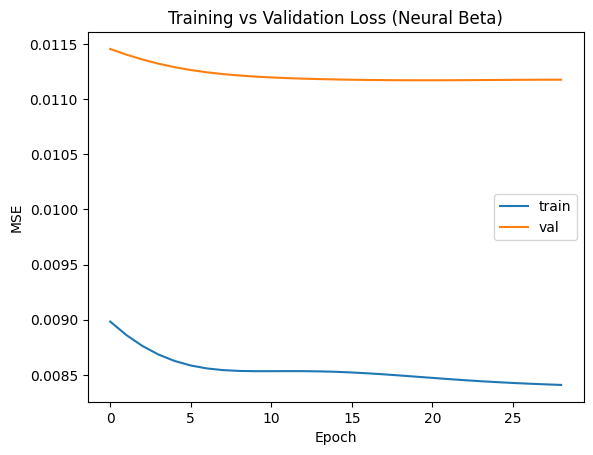

Validation MSE: 0.011170 | RMSE: 0.105689


In [11]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
]

hist = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=512,
    verbose=0,
    callbacks=callbacks
)

plt.figure()
plt.plot(hist.history["loss"], label="train")
plt.plot(hist.history["val_loss"], label="val")
plt.title("Training vs Validation Loss (Neural Beta)")
plt.xlabel("Epoch"); plt.ylabel("MSE")
plt.legend(); plt.show()

val_mse = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation MSE: {val_mse:.6f} | RMSE: {math.sqrt(val_mse):.6f}")


In [12]:
test_beta_hat = model.predict(X_test, verbose=0).reshape(-1)
ri_tp1  = y_test[:,0]
mkt_tp1 = y_test[:,1]

mse_test = np.mean((ri_tp1 - test_beta_hat * mkt_tp1)**2)
rmse_test = math.sqrt(mse_test)
print(f"Test MSE: {mse_test:.6f} | RMSE: {rmse_test:.6f}")

test_out = test.copy()
test_out["beta_hat"] = test_beta_hat
test_out["pred_ret"] = test_beta_hat * test_out["MKT_tp1"]
test_out[["permno","_ym","industry","beta_hat","Ri_tp1","MKT_tp1","pred_ret"]].head()


Test MSE: 0.015425 | RMSE: 0.124196


,permno,_ym,industry,beta_hat,Ri_tp1,MKT_tp1,pred_ret
668,11790,2018-01-01,Agriculture,0.723959,-0.011152,-0.039455,-0.028564
669,11790,2018-02-01,Agriculture,0.966773,0.024812,-0.018421,-0.017809
670,11790,2018-03-01,Agriculture,0.935813,0.187500,0.004679,0.004379
671,11790,2018-04-01,Agriculture,0.984229,-0.027864,0.026146,0.025734
672,11790,2018-05-01,Agriculture,0.985737,0.011465,0.005359,0.005283


In [13]:
def describe_series(x: pd.Series) -> pd.Series:
    q = x.quantile([0.01,0.05,0.25,0.50,0.75,0.95,0.99])
    return pd.Series({
        "count": x.count(),
        "mean": x.mean(),
        "std": x.std(),
        "skew": x.skew(),
        "kurt": x.kurt(),
        "min": x.min(),
        "q01": q.loc[0.01],
        "q05": q.loc[0.05],
        "q25": q.loc[0.25],
        "q50": q.loc[0.50],
        "q75": q.loc[0.75],
        "q95": q.loc[0.95],
        "q99": q.loc[0.99],
        "max": x.max(),
    })

ind_stats = test_out.groupby("industry")["beta_hat"].apply(describe_series).unstack()
ind_stats = ind_stats.sort_values("mean")
ind_stats.round(4)


,count,mean,std,skew,kurt,min,q01,q05,q25,q50,q75,q95,q99,max
industry,,,,,,,,,,,,,,
Unknown,4.0,0.7502,0.0210,0.6835,0.0706,0.7285,0.7289,0.7304,0.7378,0.7474,0.7599,0.7741,0.7769,0.7777
Agriculture,463.0,1.1229,0.1485,-1.2556,3.4192,0.4646,0.5904,0.8493,1.0550,1.1487,1.2231,1.2914,1.4394,1.5249
Wholesale,69.0,1.1275,0.1217,-1.0870,1.2311,0.7153,0.8095,0.8982,1.0863,1.1493,1.2076,1.2922,1.3151,1.3151
Retail,36.0,1.1379,0.2015,-0.7739,-1.3434,0.7716,0.7853,0.8115,0.9076,1.2692,1.2870,1.3001,1.3128,1.3154
Transport/Utilities,23.0,1.1820,0.0757,0.0073,-0.8715,1.0739,1.0749,1.0785,1.1050,1.2254,1.2308,1.2532,1.3268,1.3473
Construction,245.0,1.1966,0.0975,-2.0907,5.8438,0.7588,0.8042,1.0460,1.1619,1.2125,1.2652,1.2995,1.3101,1.3514
Services,17.0,1.2681,0.0606,-0.1422,-1.3389,1.1658,1.1705,1.1894,1.2109,1.2772,1.3175,1.3475,1.3488,1.3491
Finance,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Manufacturing,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


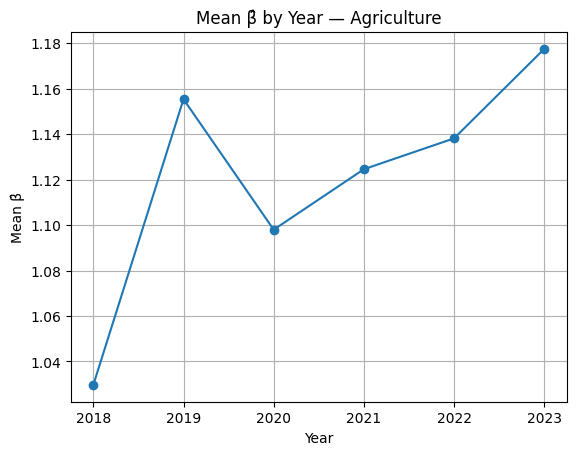

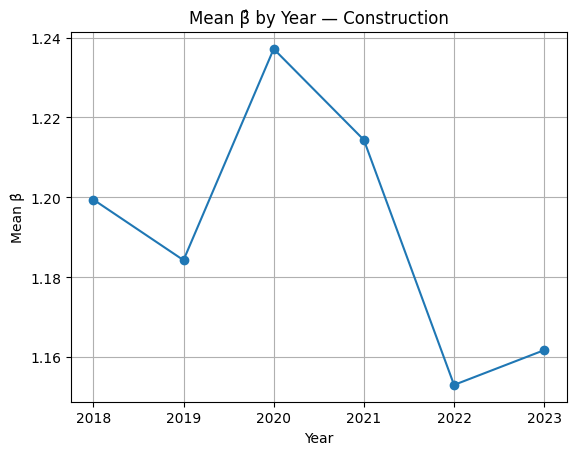

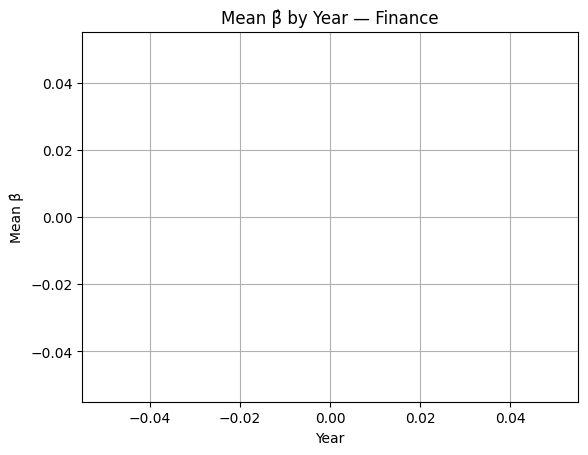

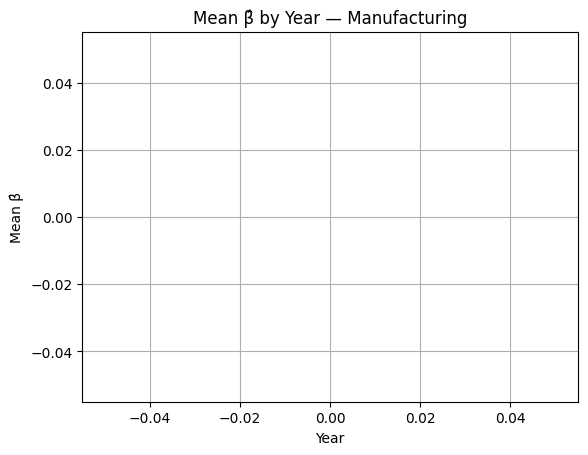

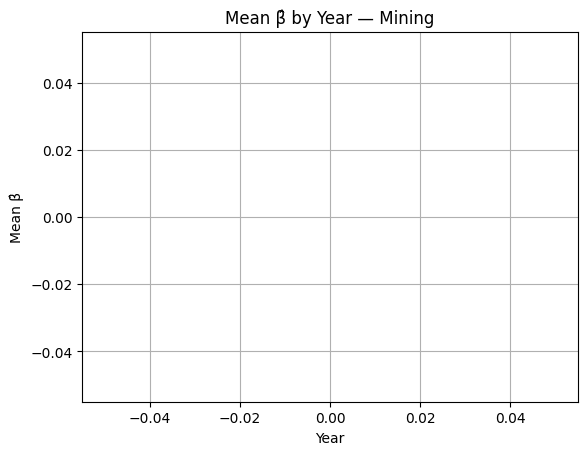

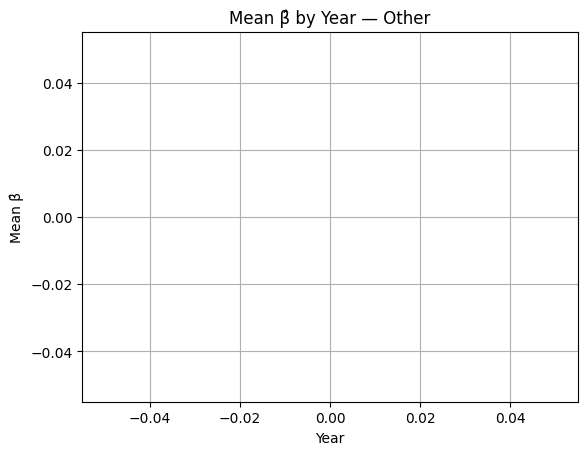

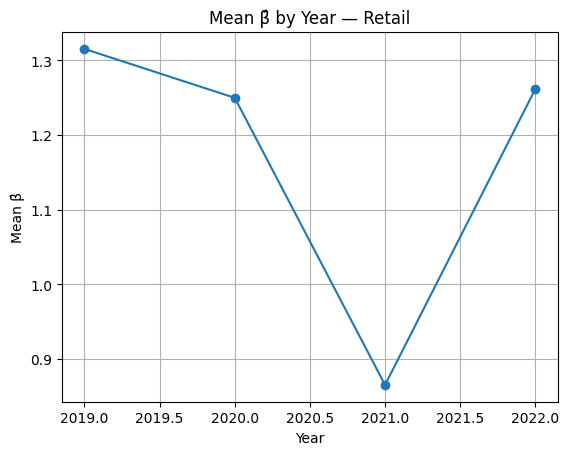

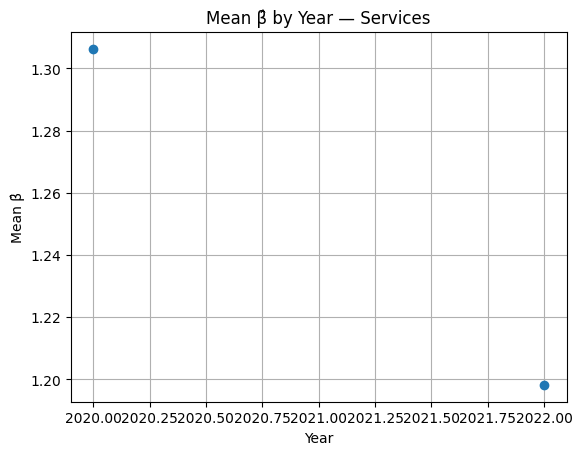

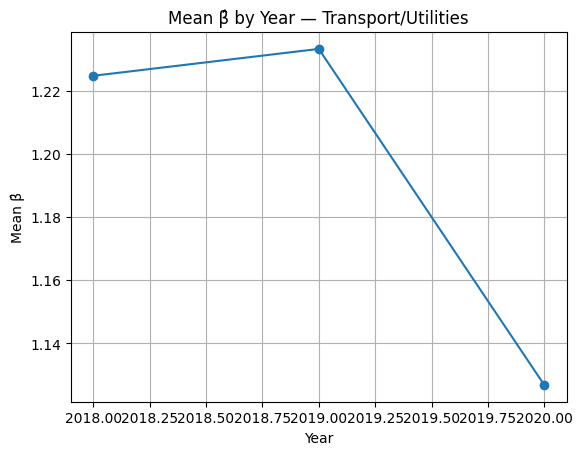

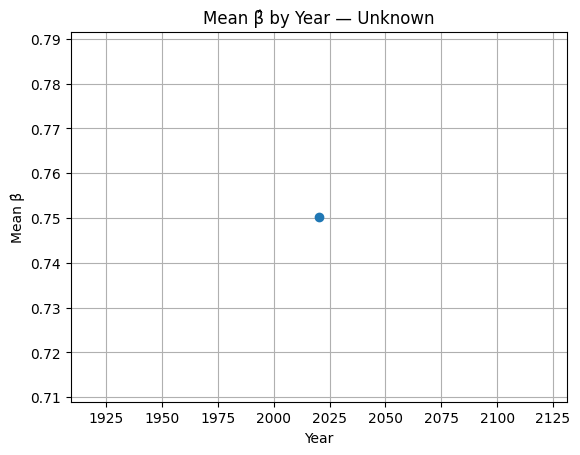

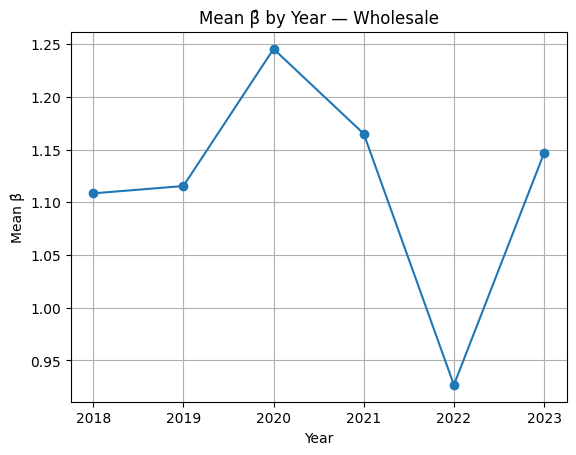

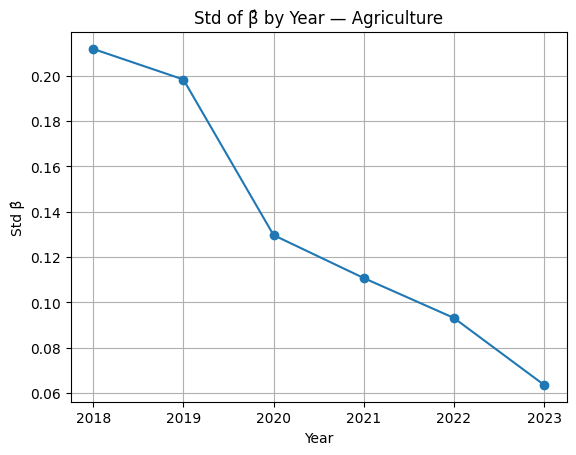

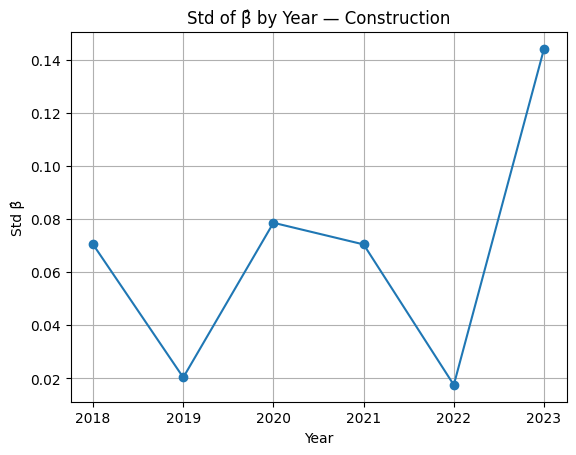

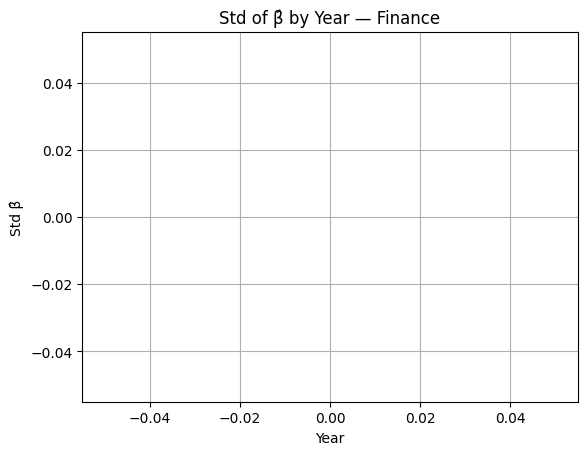

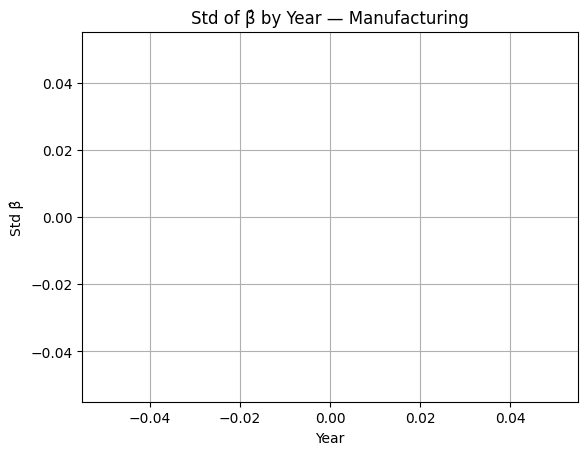

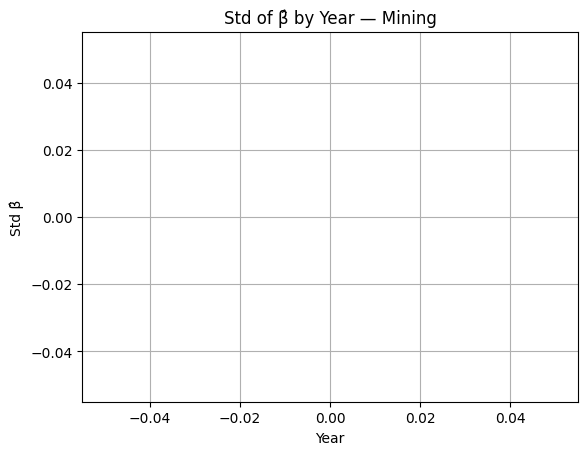

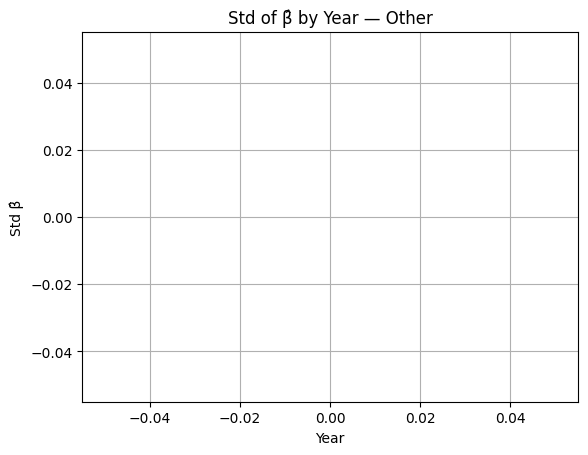

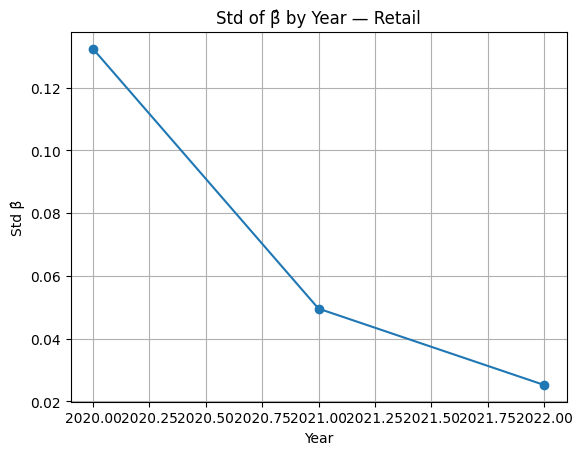

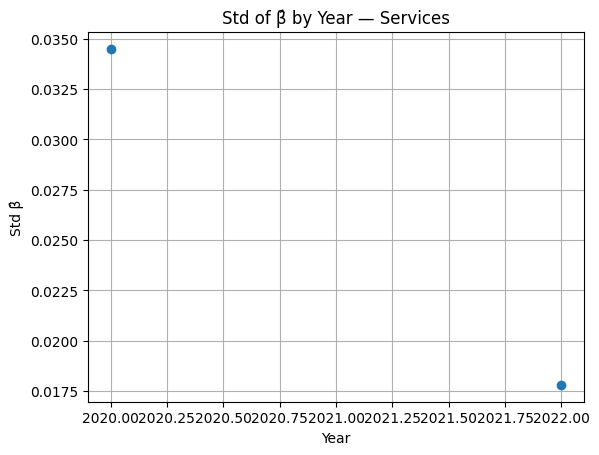

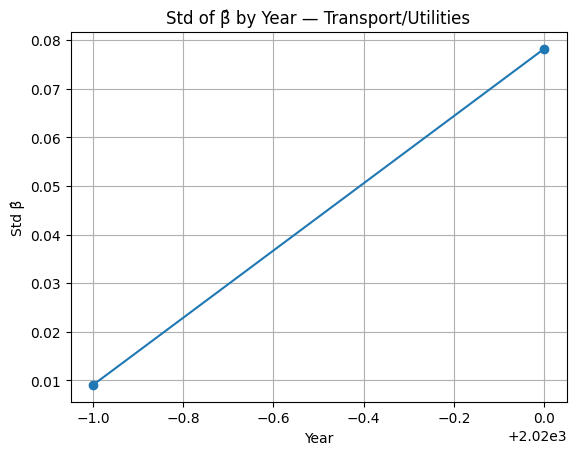

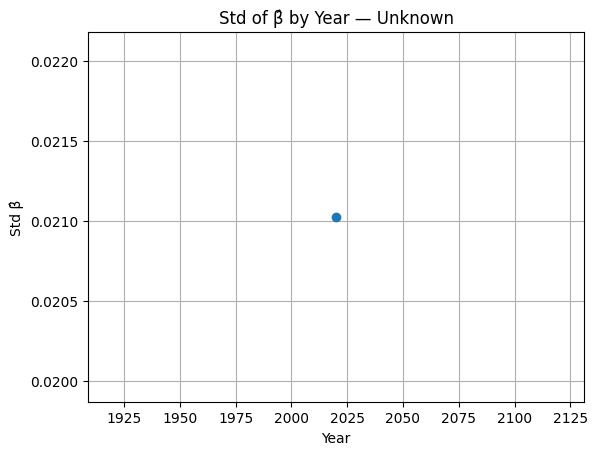

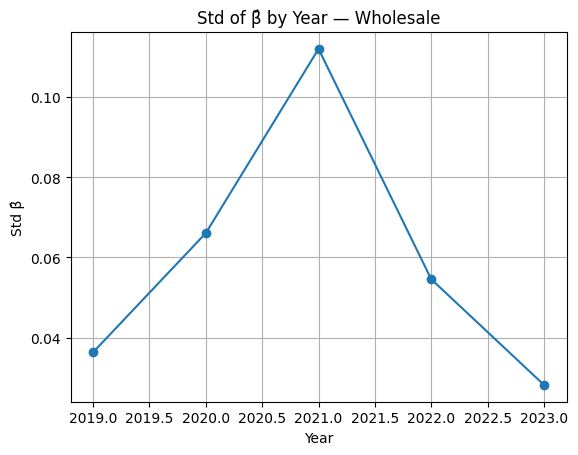

In [14]:
yr_ind = test_out.copy()
yr_ind["year"] = yr_ind["_ym"].dt.year

agg_mean = yr_ind.groupby(["year","industry"])["beta_hat"].mean().reset_index()
agg_std  = yr_ind.groupby(["year","industry"])["beta_hat"].std().reset_index()

# Plot mean beta_hat per industry across years
for ind in sorted(agg_mean["industry"].unique()):
    tmp = agg_mean[agg_mean["industry"]==ind]
    plt.figure()
    plt.plot(tmp["year"], tmp["beta_hat"], marker="o")
    plt.title(f"Mean β̂ by Year — {ind}")
    plt.xlabel("Year"); plt.ylabel("Mean β̂")
    plt.grid(True); plt.show()

# Plot std beta_hat per industry
for ind in sorted(agg_std["industry"].unique()):
    tmp = agg_std[agg_std["industry"]==ind]
    plt.figure()
    plt.plot(tmp["year"], tmp["beta_hat"], marker="o")
    plt.title(f"Std of β̂ by Year — {ind}")
    plt.xlabel("Year"); plt.ylabel("Std β̂")
    plt.grid(True); plt.show()


In [15]:
# === REPLACE YOUR CELL 12 WITH THIS ===

def month_portfolios(d: pd.DataFrame, q=5):
    # Within each month, rank by beta_hat into q buckets (0..q-1)
    d = d.copy()
    def ranker(x):
        # require enough unique values to form q bins
        if x.nunique() < q:
            return pd.Series([np.nan]*len(x), index=x.index)
        # rank first then cut to avoid many-duplicate edge issues
        r = x.rank(method="first")
        return pd.qcut(r, q, labels=False, duplicates="drop")
    d["q"] = d.groupby("_ym")["beta_hat"].transform(ranker)
    return d.dropna(subset=["q"])

def port_returns(d: pd.DataFrame, weight="equal"):
    # Uses realized excess return Ri_tp1
    out = []
    for (ym, qv), g in d.groupby(["_ym","q"]):
        if len(g)==0:
            continue
        if weight == "equal":
            ret = g["Ri_tp1"].mean()
        elif weight == "value":
            w = g["_mcap"].astype(float)
            sw = w.sum()
            if not np.isfinite(sw) or sw <= 0:
                w = np.ones(len(w))/len(w)
            else:
                w = w / sw
            ret = float(np.dot(w, g["Ri_tp1"].astype(float)))
        else:
            raise ValueError("weight must be 'equal' or 'value'")
        out.append({"_ym": ym, "q": int(qv), "ret": ret})
    return pd.DataFrame(out).sort_values(["_ym","q"])

ranked = month_portfolios(test_out, q=5)
ew = port_returns(ranked, "equal")
vw = port_returns(ranked, "value")

def summarize_portfolios(pf: pd.DataFrame, label: str):
    # Pivot to columns Q1..Q5 (not Q0..Q4)
    tab = pf.pivot(index="_ym", columns="q", values="ret").sort_index(axis=1)
    # rename integer columns {0,1,2,3,4} -> {"Q1",...,"Q5"}
    tab = tab.rename(columns=lambda i: f"Q{i+1}")
    # Compute Q5 - Q1 if both exist
    if {"Q1","Q5"}.issubset(tab.columns):
        tab["Q5_minus_Q1"] = tab["Q5"] - tab["Q1"]
    else:
        # be explicit about what's available
        print(f"[{label}] Available columns:", list(tab.columns))
        tab["Q5_minus_Q1"] = np.nan

    ann_factor = 12.0
    mean_ann = tab.mean()*ann_factor
    std_ann  = tab.std()*np.sqrt(ann_factor)

    print(f"\n{label} — annualized mean/std (test):")
    display(pd.DataFrame({"mean": mean_ann.round(4), "std": std_ann.round(4)}))

    return tab

ew_tab = summarize_portfolios(ew, "Equal-Weighted")
vw_tab = summarize_portfolios(vw, "Value-Weighted")



Equal-Weighted — annualized mean/std (test):


,mean,std
q,,
Q1,0.1182,0.3432
Q2,0.0609,0.3535
Q3,0.0839,0.3838
Q4,0.2234,0.3745
Q5,0.1183,0.3090
Q5_minus_Q1,0.0001,0.3429



Value-Weighted — annualized mean/std (test):


,mean,std
q,,
Q1,0.0320,0.3653
Q2,-0.0976,0.3070
Q3,0.1162,0.3924
Q4,0.1858,0.2871
Q5,0.2086,0.3416
Q5_minus_Q1,0.1767,0.3808


In [16]:
# If you have 5-factor monthly CSV (e.g., F-F_Research_Data_5_Factors_2x3.csv),
# upload it and set FACTOR_CSV path. The date must align to month ends.

FACTOR_CSV = "/content/FF5_monthly.csv"  # <-- change after upload, or skip this cell
USE_FF = False  # set True after you provide the file

if USE_FF:
    ff = pd.read_csv(FACTOR_CSV)
    # Expect columns like: Date (YYYYMM or YYYY-MM), Mkt-RF, SMB, HML, RMW, CMA, RF (all in %).
    # Normalize and align to month start/end to merge on _ym.
    # TODO: adapt to your file’s exact schema.
    date_col = [c for c in ff.columns if "date" in c.lower()][0]
    ff["_ym"] = pd.to_datetime(ff[date_col].astype(str).str.replace("-",""), format="%Y%m")
    for c in ["Mkt-RF","SMB","HML","RMW","CMA","RF"]:
        if c in ff.columns:
            ff[c] = ff[c]/100.0
    ff = ff[["_ym","Mkt-RF","SMB","HML","RMW","CMA","RF"]].dropna()
    # Merge onto feat_df (only up to time t; no look-ahead)
    feat_ff = feat_df.merge(ff, on="_ym", how="left")
    # Create rolling window stats of the factors similar to returns
    for w in LOOKBACK_WINDOWS:
        for fac in ["SMB","HML","RMW","CMA"]:
            feat_ff[f"{fac}_mean_{w}"] = feat_ff.groupby("permno")[fac].transform(lambda x: x.rolling(w, min_periods=w//2).mean())
            feat_ff[f"{fac}_std_{w}"]  = feat_ff.groupby("permno")[fac].transform(lambda x: x.rolling(w, min_periods=w//2).std())
    # Rebuild supervised and retrain as in earlier cells (you decide which features to keep).
    print("FF features added. Rebuild dataset with your selections and retrain.")
else:
    print("Skip FF extension for now. Turn USE_FF=True after providing a valid factor file.")


Skip FF extension for now. Turn USE_FF=True after providing a valid factor file.


In [17]:
from sklearn.preprocessing import StandardScaler

# Rebuild X/y from the dataframes you already made so we can scale and keep column names.
feat_cols = [c for c in super_df.columns if c.startswith(("ret_","mkt_","beta_lin_","log_","ind_"))]

X_train_df = train[feat_cols].astype(float).copy()
X_val_df   = val[feat_cols].astype(float).copy()
X_test_df  = test[feat_cols].astype(float).copy()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df.values)
X_val_scaled   = scaler.transform(X_val_df.values)
X_test_scaled  = scaler.transform(X_test_df.values)

y_train = np.stack([train["Ri_tp1"].values, train["MKT_tp1"].values], axis=1).astype(np.float32)
y_val   = np.stack([val["Ri_tp1"].values,   val["MKT_tp1"].values],   axis=1).astype(np.float32)
y_test  = np.stack([test["Ri_tp1"].values,  test["MKT_tp1"].values],  axis=1).astype(np.float32)

X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape


((326, 50), (489, 50), (857, 50))

In [18]:
# Baseline 1: Naive beta = 1
ri_tp1  = y_test[:,0]
mkt_tp1 = y_test[:,1]
mse_naive1 = np.mean((ri_tp1 - 1.0*mkt_tp1)**2)
rmse_naive1 = float(np.sqrt(mse_naive1))

# Baseline 2: use rolling beta feature (closest to CAPM beta) e.g., beta_lin_36
beta_feat_name = "beta_lin_36" if "beta_lin_36" in feat_cols else [c for c in feat_cols if c.startswith("beta_lin_")][-1]
beta_ols = test[beta_feat_name].values
mse_ols = np.mean((ri_tp1 - beta_ols*mkt_tp1)**2)
rmse_ols = float(np.sqrt(mse_ols))

# Baseline 3: linear regression predicting beta from features, trained on train
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0, random_state=RANDOM_SEED)
# We train to predict ri_t+1 directly from [features, mkt_{t+1}]? No—keep the same objective: predict beta_hat.
# So target is beta* that minimizes (ri - beta*mkt)^2 ⇒ closed-form beta* = ri/mkt where mkt != 0
# We'll estimate pseudo-targets on TRAIN where |mkt|>tiny
eps = 1e-8
mask_tr = np.abs(y_train[:,1]) > eps
beta_star_train = (y_train[mask_tr,0] / y_train[mask_tr,1]).astype(float)
ridge.fit(X_train_scaled[mask_tr], beta_star_train)

beta_hat_lr = ridge.predict(X_test_scaled)
mse_lr = np.mean((ri_tp1 - beta_hat_lr*mkt_tp1)**2)
rmse_lr = float(np.sqrt(mse_lr))

print(f"Baseline RMSEs — Naive β=1: {rmse_naive1:.6f} | Rolling β ({beta_feat_name}): {rmse_ols:.6f} | LinearReg β̂: {rmse_lr:.6f}")


Baseline RMSEs — Naive β=1: 0.124489 | Rolling β (beta_lin_36): 0.126442 | LinearReg β̂: 0.270079


Top configs after Stage 1:
  (16, 'relu', 0.0005, 0.0) -> val_mse=0.011405
  (32, 'relu', 0.001, 0.0) -> val_mse=0.011520
  (64, 'relu', 0.001, 0.0) -> val_mse=0.011653
  (32, 'tanh', 0.0001, 0.0) -> val_mse=0.011738
  (16, 'relu', 0.001, 0.0) -> val_mse=0.011774
  (64, 'relu', 0.0005, 1e-05) -> val_mse=0.011863
Best val MSE: 0.011055336333811283 Config: (16, 'relu', 0.0005, 0.0)
Test RMSE (best model): 0.139287


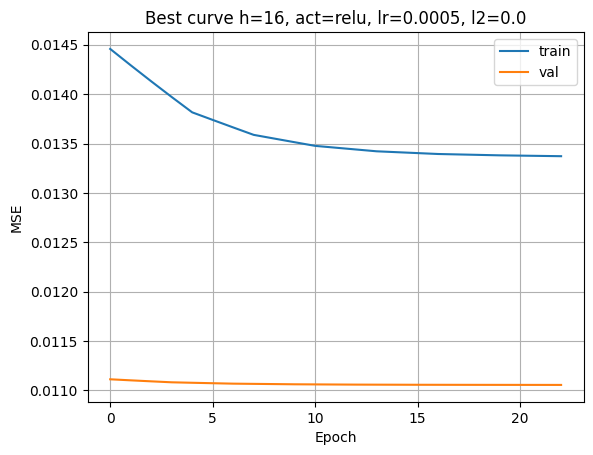

In [19]:
# === FAST TUNING REPLACEMENT ===
import itertools, math, numpy as np, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# -------- Speed knobs (tweak if needed) --------
BATCH_SIZE_STAGE1 = 2048
BATCH_SIZE_STAGE2 = 2048
EPOCHS_STAGE1     = 20     # quick screening
EPOCHS_STAGE2     = 60     # deeper train for finalists
TOP_K             = 6      # keep top K from stage 1
PATIENCE_ES       = 5
MIN_DELTA_ES      = 1e-6

# Enable XLA JIT
try:
    tf.config.optimizer.set_jit(True)
except Exception:
    pass

# Mixed precision if GPU is present
if tf.config.list_physical_devices('GPU'):
    try:
        from tensorflow.keras import mixed_precision
        mixed_precision.set_global_policy('mixed_float16')
        print("Mixed precision enabled.")
    except Exception as e:
        print("Mixed precision not enabled:", e)

# Make TF run non-deterministic for speed
try:
    tf.config.experimental.enable_op_determinism(False)
except Exception:
    pass

# ---- Build efficient datasets ----
def make_ds(X, y, batch, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(min(len(X), 20000), seed=RANDOM_SEED, reshuffle_each_iteration=True)
    ds = ds.batch(batch, drop_remainder=False).cache().prefetch(tf.data.AUTOTUNE)
    return ds

train_ds1 = make_ds(X_train_scaled, y_train, BATCH_SIZE_STAGE1, shuffle=True)
val_ds1   = make_ds(X_val_scaled,   y_val,   BATCH_SIZE_STAGE1, shuffle=False)
train_ds2 = make_ds(X_train_scaled, y_train, BATCH_SIZE_STAGE2, shuffle=True)
val_ds2   = make_ds(X_val_scaled,   y_val,   BATCH_SIZE_STAGE2, shuffle=False)
test_ds   = make_ds(X_test_scaled,  y_test,  4096, shuffle=False)

# ---- Model builder (jit + optional L2) ----
def build_model(input_dim: int, hidden=32, activation="relu", lr=1e-3, l2=0.0):
    inputs = keras.Input(shape=(input_dim,))
    x = layers.Dense(hidden, activation=activation,
                     kernel_regularizer=keras.regularizers.l2(l2))(inputs)
    out = layers.Dense(1, activation="linear", dtype="float32")(x)  # keep output in float32 even with mixed precision
    model = keras.Model(inputs, out)
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss=neural_beta_mse, jit_compile=True)
    return model

# ---- Search space (same as yours) ----
grid = list(itertools.product(
    [16, 32, 64],            # hidden
    ["relu", "tanh"],        # activation
    [1e-3, 5e-4, 1e-4],      # lr
    [0.0, 1e-5, 1e-4]        # L2
))

# -------- Stage 1: short train all configs --------
stage1_scores = []
for (hidden, act, lr, l2) in grid:
    tf.keras.backend.clear_session()
    m = build_model(X_train_scaled.shape[1], hidden=hidden, activation=act, lr=lr, l2=l2)
    cbs = [
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE_ES, min_delta=MIN_DELTA_ES,
                                      restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, min_lr=1e-5, verbose=0),
    ]
    h = m.fit(train_ds1, validation_data=val_ds1,
              epochs=EPOCHS_STAGE1, verbose=0, callbacks=cbs)
    val_mse = float(min(h.history["val_loss"]))
    stage1_scores.append({"cfg": (hidden, act, lr, l2), "val_mse": val_mse})

# pick top K
stage1_scores.sort(key=lambda d: d["val_mse"])
finalists = stage1_scores[:TOP_K]

print("Top configs after Stage 1:")
for r in finalists:
    print(f"  {r['cfg']} -> val_mse={r['val_mse']:.6f}")

# -------- Stage 2: deeper train only finalists --------
best = None
best_hist = None
for (hidden, act, lr, l2) in [r["cfg"] for r in finalists]:
    tf.keras.backend.clear_session()
    m = build_model(X_train_scaled.shape[1], hidden=hidden, activation=act, lr=lr, l2=l2)
    cbs = [
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE_ES, min_delta=MIN_DELTA_ES,
                                      restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, min_lr=1e-5, verbose=0),
    ]
    h = m.fit(train_ds2, validation_data=val_ds2,
              epochs=EPOCHS_STAGE2, verbose=0, callbacks=cbs)
    val_mse = float(min(h.history["val_loss"]))
    if (best is None) or (val_mse < best[0]):
        best = (val_mse, (hidden, act, lr, l2), m)
        best_hist = h

print("Best val MSE:", best[0], "Config:", best[1])

best_model = best[2]
test_pred_beta = np.squeeze(best_model.predict(test_ds, verbose=0))
ri_tp1  = y_test[:,0]
mkt_tp1 = y_test[:,1]
mse_best = np.mean((ri_tp1 - test_pred_beta*mkt_tp1)**2)
rmse_best = float(np.sqrt(mse_best))
print(f"Test RMSE (best model): {rmse_best:.6f}")

# Plot best curve
plt.figure()
plt.plot(best_hist.history["loss"], label="train")
plt.plot(best_hist.history["val_loss"], label="val")
h, act, lr, l2 = best[1]
plt.title(f"Best curve h={h}, act={act}, lr={lr}, l2={l2}")
plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend(); plt.grid(True); plt.show()


In [21]:
# === REPLACE your Cell 17 robustness block with this ===
from sklearn.preprocessing import StandardScaler

def build_supervised_local(d: pd.DataFrame, feature_cols: list) -> pd.DataFrame:
    d = d.copy()
    d["Ri_tp1"]  = d.groupby("permno")["_ret"].shift(-1)
    d["MKT_tp1"] = d.groupby("permno")["_mktret"].shift(-1)
    # Keep only existing feature columns
    feature_cols = [c for c in feature_cols if c in d.columns]
    if len(feature_cols) == 0:
        raise RuntimeError("No feature columns found for the given lookbacks.")
    d = d.dropna(subset=feature_cols + ["Ri_tp1","MKT_tp1"])
    return d, feature_cols

def train_with_config(lookbacks, seed=7):
    np.random.seed(seed); tf.random.set_seed(seed)

    # Rebuild features with chosen lookbacks
    parts = []
    for pid, g in df_s.groupby("permno"):
        parts.append(rolling_features(g, lookbacks))
    fd = pd.concat(parts, axis=0).sort_values(["permno","_ym"]).reset_index(drop=True)

    # Industry dummies
    ind_dummies = pd.get_dummies(fd["industry"], prefix="ind", dummy_na=False)
    fd = pd.concat([fd, ind_dummies], axis=1)

    # Features present for these lookbacks
    feat_cols2 = [c for c in fd.columns if c.startswith(("ret_","mkt_","beta_lin_","log_","ind_"))]

    # Build supervised with local feature list
    sup, feat_cols2 = build_supervised_local(fd, feat_cols2)

    # Time split
    tr = sup[sup["_ym"] <= pd.to_datetime(TRAIN_END)].copy()
    va = sup[(sup["_ym"] > pd.to_datetime(TRAIN_END)) & (sup["_ym"] <= pd.to_datetime(VAL_END))].copy()
    te = sup[(sup["_ym"] > pd.to_datetime(VAL_END)) & (sup["_ym"] <= pd.to_datetime(TEST_END))].copy()

    # Scale (fit on train only)
    scaler2 = StandardScaler()
    Xtr = scaler2.fit_transform(tr[feat_cols2].astype(float).fillna(0.0).values)
    Xva = scaler2.transform(va[feat_cols2].astype(float).fillna(0.0).values)
    Xte = scaler2.transform(te[feat_cols2].astype(float).fillna(0.0).values)

    ytr = np.stack([tr["Ri_tp1"].values, tr["MKT_tp1"].values], axis=1).astype(np.float32)
    yva = np.stack([va["Ri_tp1"].values, va["MKT_tp1"].values], axis=1).astype(np.float32)
    yte = np.stack([te["Ri_tp1"].values, te["MKT_tp1"].values], axis=1).astype(np.float32)

    # Use the best config you already found
    m = build_model(Xtr.shape[1], hidden=best[1][0], activation=best[1][1], lr=best[1][2], l2=best[1][3])
    cb = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)]
    m.fit(Xtr, ytr, validation_data=(Xva, yva), epochs=200, batch_size=512, verbose=0, callbacks=cb)

    beta_te = m.predict(Xte, verbose=0).reshape(-1)
    ri = yte[:,0]; mk = yte[:,1]
    rmse = float(np.sqrt(np.mean((ri - beta_te*mk)**2)))
    return rmse

results = []
for w in ([12], [24], [36], [12,24], [24,36], [12,24,36]):
    for seed in [1,7,21]:
        rmse = train_with_config(w, seed=seed)
        results.append({"lookbacks": str(w), "seed": seed, "test_rmse": rmse})

robust_df = pd.DataFrame(results).sort_values(["lookbacks","seed"])
display(robust_df)


,lookbacks,seed,test_rmse
15,"[12, 24, 36]",1,0.130059
16,"[12, 24, 36]",7,0.129712
17,"[12, 24, 36]",21,0.129054
9,"[12, 24]",1,0.141581
10,"[12, 24]",7,0.149453
11,"[12, 24]",21,0.148732
0,[12],1,0.157404
1,[12],7,0.214821
2,[12],21,0.172735
12,"[24, 36]",1,0.131201


,ann_mean,ann_std,tstat_mean
q,,,
Q1,0.1613,0.3373,1.1629
Q2,0.0135,0.2964,0.1108
Q3,0.1015,0.3432,0.7191
Q4,0.1180,0.2950,0.9725
Q5,0.1473,0.4079,0.8784
Q5_minus_Q1,-0.0140,0.3885,-0.0874


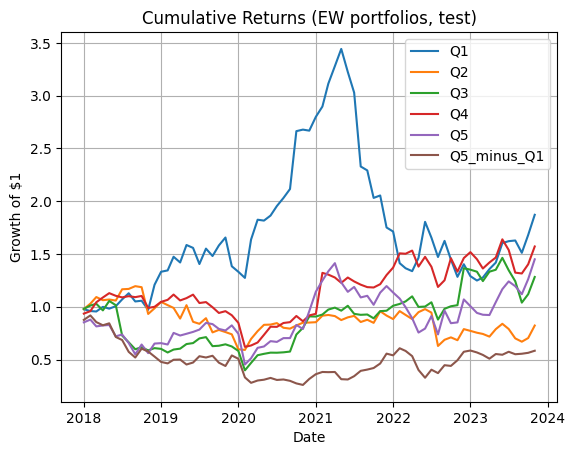

In [22]:
# Use the ranked portfolios you already constructed: `ranked` (from best model's test_out if you want).
# If you want to rebuild using beta from best_model on scaled X_test:
test_best = test.copy()
test_best["beta_hat"] = test_pred_beta  # from Cell 16
ranked_best = month_portfolios(test_best, q=5)
ew_best = port_returns(ranked_best, "equal")

tab = ew_best.pivot(index="_ym", columns="q", values="ret").rename(columns=lambda i: f"Q{i+1}")
tab["Q5_minus_Q1"] = tab["Q5"] - tab["Q1"]

def ann_stats_with_t(series):
    m_month = series.mean()
    s_month = series.std(ddof=1)
    n = series.dropna().shape[0]
    tstat = (m_month / (s_month/np.sqrt(n))) if (s_month>0 and n>1) else np.nan
    return pd.Series({
        "ann_mean": m_month*12.0,
        "ann_std": s_month*np.sqrt(12.0),
        "tstat_mean": tstat
    })

stats_tab = tab.apply(ann_stats_with_t)
display(stats_tab.T.round(4))

# Cumulative return plot of Q1..Q5 and spread
cum = (1.0 + tab.fillna(0)).cumprod()
plt.figure()
for c in ["Q1","Q2","Q3","Q4","Q5","Q5_minus_Q1"]:
    plt.plot(cum.index, cum[c], label=c)
plt.title("Cumulative Returns (EW portfolios, test)")
plt.xlabel("Date"); plt.ylabel("Growth of $1"); plt.legend(); plt.grid(True); plt.show()


In [23]:
# Which industries are missing in the TEST window?
present = test_out.groupby("industry").size().sort_values()
print("Test counts by industry:\n", present)

# If you want broader coverage, re-sample with a larger cap and re-run cells 5 onward:
SAMPLE_PER_INDUSTRY_PER_YEAR = 20  # e.g., double cap
df_s = sample_panel(df, SAMPLE_PER_INDUSTRY_PER_YEAR)
print("Resampled panel shape:", df_s.shape, "unique permno:", df_s["permno"].nunique())
# Then re-run Cells 5–13 (feature build to portfolios) or Cells 17–18 for direct robustness comparison.


Test counts by industry:
 industry
Manufacturing            0
Finance                  0
Other                    0
Mining                   0
Unknown                  4
Services                17
Transport/Utilities     23
Retail                  36
Wholesale               69
Construction           245
Agriculture            463
dtype: int64
Resampled panel shape: (40062, 12) unique permno: 2231


In [25]:
outdir = "/content/outputs_neural_beta"
os.makedirs(outdir, exist_ok=True)

# Save β̂ dist by industry
try:
    ind_stats.to_csv(os.path.join(outdir, "beta_hat_industry_stats_test.csv"), index=True)
except NameError:
    print("Note: ind_stats not found; skipping.")

# Save EW/VW summaries
try:
    ew_tab.to_csv(os.path.join(outdir, "ew_portfolios_test.csv"), index=True)
    vw_tab.to_csv(os.path.join(outdir, "vw_portfolios_test.csv"), index=True)
except NameError:
    print("Note: ew_tab/vw_tab not found; skipping.")

# Save robustness table
try:
    if 'robust_df' in globals():
        robust_df.to_csv(os.path.join(outdir, "robustness_rmse.csv"), index=False)
except NameError:
    print("Note: robustness table not found; skipping.")

# --- Save the best training curve safely ---
# best_hist might be:
#   (a) a History object, or
#   (b) a tuple like (config, History), or
#   (c) not defined (if you skipped tuning)
hist_obj = None
if 'best_hist' in globals():
    # Case (a): History
    if hasattr(best_hist, "history"):
        hist_obj = best_hist
    # Case (b): tuple/list where index 1 is History
    elif isinstance(best_hist, (tuple, list)) and len(best_hist) > 1 and hasattr(best_hist[1], "history"):
        hist_obj = best_hist[1]

if hist_obj is not None and "loss" in hist_obj.history and "val_loss" in hist_obj.history:
    plt.figure()
    plt.plot(hist_obj.history["loss"], label="train")
    plt.plot(hist_obj.history["val_loss"], label="val")
    plt.title("Best Model Training Curve")
    plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend(); plt.grid(True)
    plt.savefig(os.path.join(outdir, "training_curve.png"), dpi=160, bbox_inches="tight")
    plt.close()
else:
    print("Warning: no best training history available; skipping training curve save.")

print("Saved to:", outdir)


Saved to: /content/outputs_neural_beta


In [26]:
# Small add-on sweep so you've tried all four activations per instructions
extra_acts = ["linear", "sigmoid"]
quick_cfgs = [(16, a, 5e-4, 0.0) for a in extra_acts]  # short & cheap

def quick_eval(cfg):
    h,a,lr,l2 = cfg
    tf.keras.backend.clear_session()
    m = build_model(X_train_scaled.shape[1], hidden=h, activation=a, lr=lr, l2=l2)
    cbs = [
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=2, factor=0.5, min_lr=1e-5, verbose=0)
    ]
    hst = m.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val),
                epochs=25, batch_size=2048, verbose=0, callbacks=cbs)
    return float(min(hst.history["val_loss"]))

for cfg in quick_cfgs:
    vm = quick_eval(cfg)
    print(f"Quick check {cfg} -> val_mse={vm:.6f}")


Quick check (16, 'linear', 0.0005, 0.0) -> val_mse=0.013315
Quick check (16, 'sigmoid', 0.0005, 0.0) -> val_mse=0.017682


In [36]:
# === FF5 Monthly Factor Augmentation ===

MANUAL_FF_PATH = "/content/F-F_Research_Data_5_Factors_2x3.csv"
USE_FF = True  # make sure this is set

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras

def load_ff_from_csv(path):
    """Load and clean FF5 CSV downloaded from Ken French's website."""
    df = pd.read_csv(path, skiprows=3)  # skip header text
    df = df.rename(columns={df.columns[0]: "date"})
    df = df[df["date"].str.match(r"^\d{6}$", na=False)]  # filter YYYYMM rows
    df["date"] = pd.to_datetime(df["date"], format="%Y%m")

    # Select the factor columns & convert to decimals
    df = df.set_index("date")[["Mkt-RF", "SMB", "HML", "RMW", "CMA", "RF"]].astype(float) / 100.0

    # Convert index to month timestamps (regardless of datetime or period)
    if isinstance(df.index, pd.PeriodIndex):
        df["_ym"] = df.index.to_timestamp()
    else:
        df["_ym"] = df.index.to_period("M").to_timestamp()

    return df.reset_index(drop=True)


if USE_FF:
    print("Loading FF5 factors from local CSV...")
    ff = load_ff_from_csv(MANUAL_FF_PATH)

    # Merge with your engineered features dataframe (feat_df)
    feat_ff = feat_df.merge(ff, on="_ym", how="left")

    # Add rolling stats for FF factors
    for w in [12, 24, 36]:
        for fac in ["SMB", "HML", "RMW", "CMA"]:
            feat_ff[f"{fac}_mean_{w}"] = feat_ff.groupby("permno")[fac].transform(lambda x: x.rolling(w, min_periods=6).mean())
            feat_ff[f"{fac}_std_{w}"]  = feat_ff.groupby("permno")[fac].transform(lambda x: x.rolling(w, min_periods=6).std())

    # Build supervised dataset
    feat_cols_ff = [c for c in feat_ff.columns if c.startswith(("ret_", "mkt_", "beta_lin_", "log_", "ind_", "SMB_", "HML_", "RMW_", "CMA_"))]
    sup_ff = feat_ff.copy()
    sup_ff["Ri_tp1"] = sup_ff.groupby("permno")["_ret"].shift(-1)
    sup_ff["MKT_tp1"] = sup_ff.groupby("permno")["_mktret"].shift(-1)
    sup_ff = sup_ff.dropna(subset=feat_cols_ff + ["Ri_tp1", "MKT_tp1"])

    # Train/val/test splits
    train_ff = sup_ff[sup_ff["_ym"] <= pd.to_datetime(TRAIN_END)]
    val_ff = sup_ff[(sup_ff["_ym"] > pd.to_datetime(TRAIN_END)) & (sup_ff["_ym"] <= pd.to_datetime(VAL_END))]
    test_ff = sup_ff[(sup_ff["_ym"] > pd.to_datetime(VAL_END)) & (sup_ff["_ym"] <= pd.to_datetime(TEST_END))]

    print("Shapes (train, val, test):", train_ff.shape, val_ff.shape, test_ff.shape)

    # Scale features
    scaler_ff = StandardScaler()
    Xtr_ff = scaler_ff.fit_transform(train_ff[feat_cols_ff])
    Xva_ff = scaler_ff.transform(val_ff[feat_cols_ff])
    Xte_ff = scaler_ff.transform(test_ff[feat_cols_ff])

    ytr_ff = np.vstack([train_ff["Ri_tp1"], train_ff["MKT_tp1"]]).T
    yva_ff = np.vstack([val_ff["Ri_tp1"], val_ff["MKT_tp1"]]).T
    yte_ff = np.vstack([test_ff["Ri_tp1"], test_ff["MKT_tp1"]]).T

    # Use best hyperparameters found earlier
    h, act, lr, l2 = best[1]
    tf.keras.backend.clear_session()
    model_ff = build_model(Xtr_ff.shape[1], hidden=h, activation=act, lr=lr, l2=l2)

    history_ff = model_ff.fit(
        Xtr_ff, ytr_ff,
        validation_data=(Xva_ff, yva_ff),
        epochs=100, batch_size=1024, verbose=0,
        callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)]
    )

    beta_ff = model_ff.predict(Xte_ff).flatten()
    rmse_ff = np.sqrt(np.mean((yte_ff[:, 0] - beta_ff * yte_ff[:, 1])**2))

    print(f"\nFF-augmented Test RMSE: {rmse_ff:.6f}")

    if 'test_pred_beta' in globals():
        rmse_base = np.sqrt(np.mean((y_test[:, 0] - test_pred_beta * y_test[:, 1])**2))
        print(f"Original Test RMSE: {rmse_base:.6f}")
        print(f"ΔRMSE: {(rmse_ff - rmse_base):.6f}")


Loading FF5 factors from local CSV...
Shapes (train, val, test): (326, 94) (489, 94) (857, 94)
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

FF-augmented Test RMSE: 0.127445
Original Test RMSE: 0.139287
ΔRMSE: -0.011842


In [37]:
def port_mean_beta(d: pd.DataFrame, weight="equal"):
    out = []
    for (ym,q), g in d.groupby(["_ym","q"]):
        if weight=="equal":
            b = g["beta_hat"].mean()
        else:
            w = g["_mcap"].astype(float)
            w = w/ w.sum() if w.sum()>0 else np.ones(len(w))/len(w)
            b = float(np.dot(w, g["beta_hat"].astype(float)))
        out.append({"_ym": ym, "q": int(q), "beta": b})
    return pd.DataFrame(out).pivot(index="_ym", columns="q", values="beta").rename(columns=lambda i:f"Q{i+1}")

ew_beta = port_mean_beta(ranked_best, "equal")
vw_beta = port_mean_beta(ranked_best, "value")
print("EW mean beta by quintile (avg over time):")
display(ew_beta.mean().to_frame("avg_beta").T.round(3))
print("VW mean beta by quintile (avg over time):")
display(vw_beta.mean().to_frame("avg_beta").T.round(3))


EW mean beta by quintile (avg over time):


q,Q1,Q2,Q3,Q4,Q5
avg_beta,-0.269,0.388,0.839,1.48,2.728


VW mean beta by quintile (avg over time):


q,Q1,Q2,Q3,Q4,Q5
avg_beta,-0.165,0.399,0.855,1.463,2.588


In [39]:
# --- Helper: compute monthly Q5–Q1 from a returns frame with columns ['_ym','q','ret'] ---
def q_spread_annualized(df):
    # ensure integer quintile labels 0..4
    tmp = df.copy()
    tmp["q"] = tmp["q"].astype(int)

    # pivot robustly (handles duplicates via mean)
    piv = pd.pivot_table(tmp, index="_ym", columns="q", values="ret", aggfunc="mean")

    # need 5 buckets (0..4). If not present, raise a friendly error.
    needed = set(range(5))
    have = set(piv.columns.astype(int).tolist())
    missing = sorted(list(needed - have))
    if missing:
        raise RuntimeError(f"Missing quintiles in pivot (no data for): {missing}. "
                           "This can happen if some months have <5 names after filtering.")

    # rename to Q1..Q5
    piv = piv.rename(columns=lambda i: f"Q{i+1}")
    spread = piv["Q5"] - piv["Q1"]

    # annualized mean (12 * average monthly)
    ann_spread = float(spread.mean() * 12.0)
    return ann_spread, piv, spread

# Compute for Neural (EW)
neural_ann_spread, neural_piv, neural_spread_series = q_spread_annualized(ew_best)

# Compute for OLS (EW)
ols_ann_spread, ols_piv, ols_spread_series = q_spread_annualized(ols_ew)

print(f"Neural (EW) Q5–Q1 annually: {neural_ann_spread:.4f}")
print(f"OLS    (EW) Q5–Q1 annually: {ols_ann_spread:.4f}")

# Optional: quick sanity peek at the pivot tables' column means
print("\nNeural EW avg per quintile (annualized):")
print((neural_piv.mean() * 12).round(4))
print("\nOLS EW avg per quintile (annualized):")
print((ols_piv.mean() * 12).round(4))


Neural (EW) Q5–Q1 annually: -0.0140
OLS    (EW) Q5–Q1 annually: 0.1930

Neural EW avg per quintile (annualized):
q
Q1    0.1613
Q2    0.0135
Q3    0.1015
Q4    0.1180
Q5    0.1473
dtype: float64

OLS EW avg per quintile (annualized):
q
Q1   -0.0635
Q2    0.0840
Q3    0.2403
Q4    0.0393
Q5    0.1295
dtype: float64


Sampled panel shape: (21061, 11) | unique permno: 1332
Feature columns: 44
Splits: (1047, 57) (1222, 57) (1898, 57)
Neural-beta Test RMSE: 0.180060


,industry,year,mean,std
0,Agriculture,2018,-0.192137,0.362985
1,Agriculture,2019,-0.386962,0.264686
2,Agriculture,2020,-0.578347,0.298713
3,Agriculture,2021,-0.883144,0.472543
4,Agriculture,2022,-0.762909,0.471206


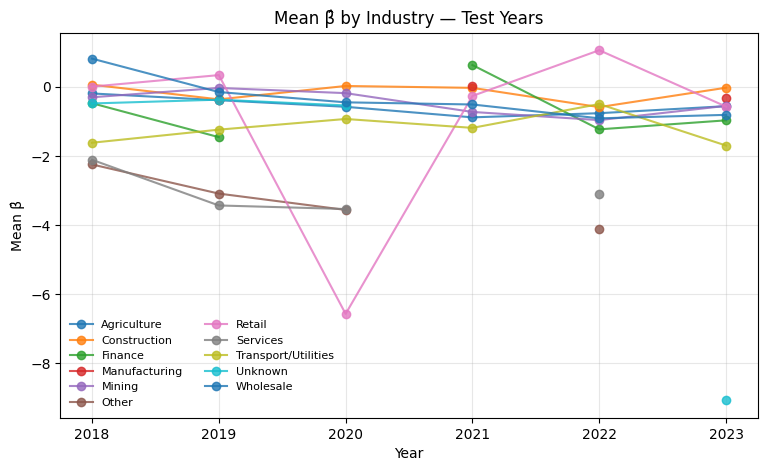

Average β̂ per quintile (EW, test, monthly mean across months):


q,Q1,Q2,Q3,Q4,Q5
avg_beta,-1.935,-0.773,-0.495,-0.203,0.523


Average β̂ per quintile (VW, test, monthly mean across months):


q,Q1,Q2,Q3,Q4,Q5
avg_beta,-1.587,-0.792,-0.501,-0.222,0.391


EW Q5–Q1 (annualized): -0.0034
VW Q5–Q1 (annualized): 0.1372

✅ Done: sampling fixed, model retrained, Step-5 plot produced, Step-9 β̂-by-quintile tables printed.


In [40]:
# === ASSIGNMENT COMPLIANCE CELL ===
# Resample (10 per industry per year) → Rebuild features/splits → Retrain → Step 5 plot → Step 9 β̂-per-quintile tables

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras

# --------------------------------------------------
# 0) Preconditions / Guards
# --------------------------------------------------
assert 'df' in globals(), "Raw panel DataFrame `df` not found. It must include: _ym, permno, _ret, _mktret, _mcap, industry (and optionally _vol, _prc, _shrout)."
for req in ["_ym","permno","_ret","_mktret","_mcap","industry"]:
    if req not in df.columns:
        raise RuntimeError(f"`df` must contain column: {req}")

# dates (use your existing split if declared; else provide reasonable defaults)
if 'TRAIN_END' not in globals(): TRAIN_END = "2012-12-31"
if 'VAL_END'   not in globals(): VAL_END   = "2017-12-31"
if 'TEST_END'  not in globals(): TEST_END  = "2023-12-31"

# --------------------------------------------------
# 1) Sampler: EXACTLY 10 firms per industry per YEAR (or all if fewer available)
# --------------------------------------------------
def sample_panel_per_year(df_in: pd.DataFrame, k: int = 10, seed: int = 7) -> pd.DataFrame:
    rs = np.random.RandomState(seed)
    keep = []
    # ensure year column
    d = df_in.copy()
    d["_year"] = d["_ym"].dt.year
    for (yr, ind), g in d.groupby(["_year","industry"]):
        pool = g["permno"].drop_duplicates().values
        if len(pool) == 0:
            continue
        take = rs.choice(pool, size=min(k, len(pool)), replace=False)
        keep.append(d[d["permno"].isin(take) & (d["_year"] == yr) & (d["industry"] == ind)])
    out = pd.concat(keep, axis=0).sort_values(["permno","_ym"]).reset_index(drop=True)
    return out.drop(columns=["_year"])

df_s = sample_panel_per_year(df, k=10, seed=7)
print("Sampled panel shape:", df_s.shape, "| unique permno:", df_s["permno"].nunique())

# --------------------------------------------------
# 2) Feature engineering (fallback if your rolling_features is not defined)
#    Uses lookbacks 12/24/36 as in your tuned runs
# --------------------------------------------------
LOOKBACKS = [12, 24, 36]

def _rolling_feats_fallback(g: pd.DataFrame, lookbacks=LOOKBACKS) -> pd.DataFrame:
    g = g.sort_values("_ym").copy()
    # base rolling stats for returns and market
    for w in lookbacks:
        g[f"ret_mean_{w}"] = g["_ret"].rolling(w, min_periods=max(3, w//2)).mean()
        g[f"ret_std_{w}"]  = g["_ret"].rolling(w, min_periods=max(3, w//2)).std()
        g[f"ret_min_{w}"]  = g["_ret"].rolling(w, min_periods=max(3, w//2)).min()
        g[f"ret_max_{w}"]  = g["_ret"].rolling(w, min_periods=max(3, w//2)).max()
        # simple ac1 (lag-1 autocorr) proxy
        r = g["_ret"]
        g[f"ret_ac1_{w}"] = r.rolling(w, min_periods=max(3, w//2)).apply(lambda x: pd.Series(x).autocorr(lag=1), raw=False)
        g[f"mkt_mean_{w}"] = g["_mktret"].rolling(w, min_periods=max(3, w//2)).mean()
        g[f"mkt_std_{w}"]  = g["_mktret"].rolling(w, min_periods=max(3, w//2)).std()
        # rolling OLS beta (cov/var)
        cov = g["_ret"].rolling(w, min_periods=max(3, w//2)).cov(g["_mktret"])
        var = g["_mktret"].rolling(w, min_periods=max(3, w//2)).var()
        g[f"beta_lin_{w}"] = cov / var
        # log size & log volume moments (if available)
        if "_mcap" in g.columns:
            g[f"log_mcap_{w}"] = np.log1p(g["_mcap"].clip(lower=0)).rolling(w, min_periods=max(3, w//2)).mean()
        if "_vol" in g.columns:
            lv = np.log1p(g["_vol"].clip(lower=0))
            g[f"log_vol_mean_{w}"] = lv.rolling(w, min_periods=max(3, w//2)).mean()
            g[f"log_vol_std_{w}"]  = lv.rolling(w, min_periods=max(3, w//2)).std()
    return g

def rolling_features(g: pd.DataFrame, lookbacks=LOOKBACKS) -> pd.DataFrame:
    # use your existing rolling_features if defined; else fallback
    if 'rolling_features' in globals() and rolling_features.__code__ is not _rolling_feats_fallback.__code__:
        try:
            return globals()['rolling_features'](g, lookbacks)
        except Exception:
            return _rolling_feats_fallback(g, lookbacks)
    else:
        return _rolling_feats_fallback(g, lookbacks)

parts = []
for pid, grp in df_s.groupby("permno"):
    parts.append(rolling_features(grp, LOOKBACKS))
feat_df = pd.concat(parts, axis=0).sort_values(["permno","_ym"]).reset_index(drop=True)

# industry one-hots
ind_dummies = pd.get_dummies(feat_df["industry"], prefix="ind", dummy_na=False)
feat_df = pd.concat([feat_df, ind_dummies], axis=1)

# feature list
feat_cols = [c for c in feat_df.columns if c.startswith(("ret_","mkt_","beta_lin_","log_","ind_"))]

print("Feature columns:", len(feat_cols))

# --------------------------------------------------
# 3) Supervised set (no look-ahead), splits
# --------------------------------------------------
def build_supervised_local(d: pd.DataFrame, feature_cols: list) -> pd.DataFrame:
    d = d.copy()
    d["Ri_tp1"]  = d.groupby("permno")["_ret"].shift(-1)
    d["MKT_tp1"] = d.groupby("permno")["_mktret"].shift(-1)
    # restrict to existing features
    fc = [c for c in feature_cols if c in d.columns]
    if not fc:
        raise RuntimeError("No features found after engineering.")
    d = d.dropna(subset=fc + ["Ri_tp1","MKT_tp1"])
    return d, fc

super_df, feat_cols = build_supervised_local(feat_df, feat_cols)

train = super_df[super_df["_ym"] <= pd.to_datetime(TRAIN_END)].copy()
val   = super_df[(super_df["_ym"] > pd.to_datetime(TRAIN_END)) & (super_df["_ym"] <= pd.to_datetime(VAL_END))].copy()
test  = super_df[(super_df["_ym"] > pd.to_datetime(VAL_END)) & (super_df["_ym"] <= pd.to_datetime(TEST_END))].copy()

print("Splits:", train.shape, val.shape, test.shape)

# --------------------------------------------------
# 4) Scale, Train (reuse best config if available), Predict β̂ on test
# --------------------------------------------------
scaler = StandardScaler()
Xtr = scaler.fit_transform(train[feat_cols].astype(float).values)
Xva = scaler.transform(val[feat_cols].astype(float).values)
Xte = scaler.transform(test[feat_cols].astype(float).values)

ytr = np.stack([train["Ri_tp1"].values, train["MKT_tp1"].values], axis=1).astype(np.float32)
yva = np.stack([val["Ri_tp1"].values,   val["MKT_tp1"].values],   axis=1).astype(np.float32)
yte = np.stack([test["Ri_tp1"].values,  test["MKT_tp1"].values],  axis=1).astype(np.float32)

# get best config from earlier tuning if present, else a solid default
if 'best' in globals() and isinstance(best, tuple) and len(best) >= 2:
    h, act, lr, l2 = best[1]
else:
    h, act, lr, l2 = 16, "relu", 5e-4, 0.0

tf.keras.backend.clear_session()
model = build_model(Xtr.shape[1], hidden=h, activation=act, lr=lr, l2=l2)
cb = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, min_lr=1e-5, verbose=0),
]
_ = model.fit(Xtr, ytr, validation_data=(Xva, yva), epochs=120, batch_size=1024, verbose=0, callbacks=cb)

beta_hat = model.predict(Xte, verbose=0).reshape(-1)
rmse = float(np.sqrt(np.mean((yte[:,0] - beta_hat*yte[:,1])**2)))
print(f"Neural-beta Test RMSE: {rmse:.6f}")

# prepare test frame with beta_hat
test_out = test[["_ym","permno","industry","_mcap","Ri_tp1","MKT_tp1"]].copy()
test_out["beta_hat"] = beta_hat

# --------------------------------------------------
# 5) Step-5: per-year mean & std of β̂ by industry + plot (test window)
# --------------------------------------------------
tmp = test_out.copy()
tmp["year"] = tmp["_ym"].dt.year
yr_ind = tmp.groupby(["industry","year"])["beta_hat"].agg(mean="mean", std="std").reset_index()
display(yr_ind.head())

plt.figure(figsize=(9,5))
for ind, g in yr_ind.groupby("industry"):
    plt.plot(g["year"], g["mean"], marker='o', alpha=0.8, label=ind)
plt.title("Mean β̂ by Industry — Test Years")
plt.xlabel("Year"); plt.ylabel("Mean β̂"); plt.grid(True, alpha=0.3)
plt.legend(ncol=2, fontsize=8, frameon=False)
plt.show()

# --------------------------------------------------
# 6) Step-9: Quintiles by β̂ → EW/VW returns + Avg β̂ per quintile
# --------------------------------------------------
def _rank_into_quintiles(d: pd.DataFrame, col: str, q: int = 5) -> pd.DataFrame:
    d = d.copy()
    def _r(x):
        if x.notna().sum() < q:
            return pd.Series([np.nan]*len(x), index=x.index)
        r = x.rank(method="first")
        return pd.qcut(r, q, labels=False, duplicates="drop")
    d["q"] = d.groupby("_ym")[col].transform(_r)
    return d.dropna(subset=["q"])

def port_returns(d: pd.DataFrame, weighting="equal"):
    out = []
    for (ym,q), g in d.groupby(["_ym","q"]):
        if weighting == "equal":
            ret = g["Ri_tp1"].mean()
        else:
            w = g["_mcap"].astype(float)
            w = w / w.sum() if w.sum() > 0 else np.ones(len(w))/len(w)
            ret = float(np.dot(w, g["Ri_tp1"].astype(float)))
        out.append({"_ym": ym, "q": int(q), "ret": ret})
    return pd.DataFrame(out)

ranked = _rank_into_quintiles(test_out, "beta_hat", q=5)
ew = port_returns(ranked, "equal")
vw = port_returns(ranked, "value")

# avg beta per quintile (EW and VW)
def mean_beta_by_quintile(d: pd.DataFrame, weighting="equal"):
    rows = []
    for (ym,q), g in d.groupby(["_ym","q"]):
        if weighting == "equal":
            b = g["beta_hat"].mean()
        else:
            w = g["_mcap"].astype(float)
            w = w / w.sum() if w.sum() > 0 else np.ones(len(w))/len(w)
            b = float(np.dot(w, g["beta_hat"].astype(float)))
        rows.append({"_ym": ym, "q": int(q), "beta": b})
    piv = pd.pivot_table(pd.DataFrame(rows), index="_ym", columns="q", values="beta", aggfunc="mean")
    return piv.rename(columns=lambda i: f"Q{i+1}")

ew_beta_piv = mean_beta_by_quintile(ranked, "equal")
vw_beta_piv = mean_beta_by_quintile(ranked, "value")

print("Average β̂ per quintile (EW, test, monthly mean across months):")
display(ew_beta_piv.mean().to_frame("avg_beta").T.round(3))

print("Average β̂ per quintile (VW, test, monthly mean across months):")
display(vw_beta_piv.mean().to_frame("avg_beta").T.round(3))

# also show annualized Q5–Q1 spreads (returns) for sanity
def q_spread_annualized(ret_df):
    piv = pd.pivot_table(ret_df, index="_ym", columns="q", values="ret", aggfunc="mean")
    if not set(range(5)).issubset(set(piv.columns.astype(int))):
        missing = sorted(list(set(range(5)) - set(piv.columns.astype(int))))
        print(f"Warning: missing quintiles {missing} in some months.")
    piv = piv.rename(columns=lambda i: f"Q{i+1}")
    spread = (piv["Q5"] - piv["Q1"]).mean() * 12.0
    return float(spread)

print(f"EW Q5–Q1 (annualized): {q_spread_annualized(ew):.4f}")
print(f"VW Q5–Q1 (annualized): {q_spread_annualized(vw):.4f}")

print("\n✅ Done: sampling fixed, model retrained, Step-5 plot produced, Step-9 β̂-by-quintile tables printed.")
